# 1. Obtain the prediction mask for all images

In [1]:
import os
import cv2
import json
import uuid
import numpy as np
from glob import glob 
import tensorflow as tf
from tqdm import tqdm
from xrExper.model_test import model
model = model(img_height=384, img_width=508, classes=2)
model.load_weights('/home/featurize/AC_Regression/xrExper/my_model_weights.weights.h5')

2025-08-11 03:15:25.460973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 03:15:25.494851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-11 03:15:26.168486: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-08-11 03:15:26.918148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See 

*** Output Shape: (None, 384, 508, 2) ***


In [2]:
input_dir = '/home/featurize/data/segmentation_dataset/images'
output_dir = '/home/featurize/data/masks_pred'
os.makedirs(output_dir, exist_ok=True)

orig_size = (744, 562)
input_size = [384, 508]

def read_png(images_path):
    images = tf.io.read_file(images_path)
    images = tf.image.decode_png(images, channels=3)
    return images

def normalize(images):
    return tf.cast(images, tf.float32) / 127.5 - 1.0

image_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
for filename in tqdm(image_files, desc="Predicting masks"):
    img_path = os.path.join(input_dir, filename)
    img = read_png(img_path)
    img = tf.image.resize(img, input_size)
    img = normalize(img)
    img = tf.expand_dims(img, axis=0)  # (1, 384, 508, 3)

    pred = model.predict(img, verbose=0)
    pred_mask = tf.argmax(pred, axis=-1)[0].numpy().astype(np.uint8)

    pred_mask_resized = cv2.resize(pred_mask, orig_size, interpolation=cv2.INTER_NEAREST)

    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, pred_mask_resized)

print(f"All prediction masks have been saved to: {output_dir}")


Predicting masks: 100%|██████████| 6620/6620 [06:10<00:00, 17.88it/s]

All prediction masks have been saved to: /home/featurize/data/masks_pred


# 2. Calculate the AC value of the predicted mask and obtain the json file

In [3]:
from dataset_construction.calculate_ac_from_mask import *

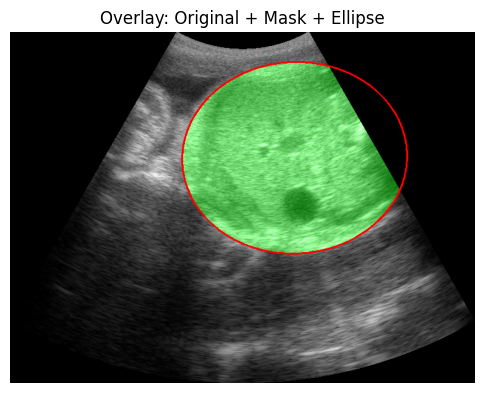

Fit ellipse ≈ 294.45 mm


In [4]:
perimeter = fit_ellipse_ac_mm("/home/featurize/data/segmentation_dataset/masks/frame_000250.png", show_plot=True)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

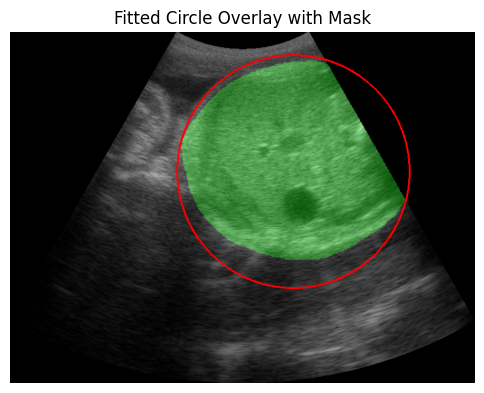

Fit ellipse ≈ 316.35 mm


In [5]:
mask_path = "/home/featurize/data/masks_pred/frame_000250.png"
perimeter = fit_circle_ac_mm(mask_path, show_plot=True, scale_factor=0.965)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

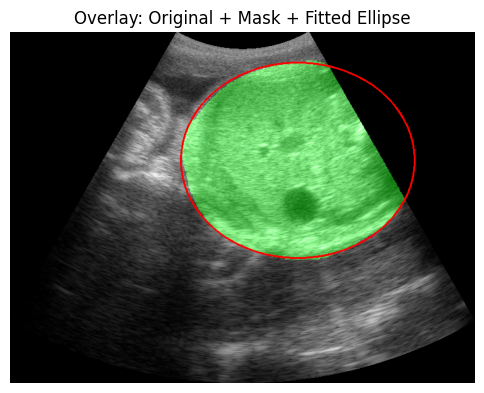

Fit ellipse ≈ 303.46 mm


In [6]:
mask_path = "/home/featurize/data/masks_pred/frame_000250.png"
smoothed_path = preprocess_and_save_smoothed_mask(mask_path, out_path="smoothed_temp.png", ksize=(71,71), sigma=4)
# smoothed_path = refine_mask_with_snake(mask_path)
perimeter = fit_ellipse_ac_mm_pred(mask_path, show_plot=True, scale_factor=1, epsilon=0.01)

# perimeter = refine_and_calculate_ac(mask_path, show_plot=True)
print(f"Fit ellipse ≈ {perimeter:.2f} mm")

In [7]:
mask_dir = "/home/featurize/data/masks_pred"
output_json = "/home/featurize/AC_Regression/results/ac_pred.json"
ac_pred = {}

mask_files = sorted(glob(os.path.join(mask_dir, "*.png")))

for path in mask_files:
    filename = os.path.basename(path)
    try:
        temp_path = f"temp_smooth_{uuid.uuid4().hex[:8]}.png"
        smoothed_path = preprocess_and_save_smoothed_mask(path, out_path=temp_path, ksize=(71,71), sigma=4)
        # smoothed_path = refine_mask_with_snake(path, out_path=temp_path)
        ac_value = fit_ellipse_ac_mm_pred(smoothed_path, show_plot=False, scale_factor=1, epsilon=0.0015)
        # ac_value = fit_circle_ac_mm(mask_path, show_plot=False, scale_factor=0.965)
        
        ac_pred[filename] = {"ac_mm": round(ac_value, 2)}
        os.remove(temp_path)
    except Exception as e:
        ac_pred[filename] = {"ac_mm": None}
        print(f"{filename} fitting error: {e}")

with open(output_json, "w") as f:
    json.dump(ac_pred, f, indent=2)

print(f"AC calculation completed: {len(mask_files)} images processed. Results saved to {output_json}")


AC calculation completed: 6620 images processed. Results saved to /home/featurize/AC_Regression/results/ac_pred.json


# 3. Set up the AC regression prediction dataset

In [8]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

with open("/home/featurize/AC_Regression/results/ac_results.json", "r") as f:
    ac_gt = json.load(f)
with open("/home/featurize/AC_Regression/results/ac_pred.json", "r") as f:
    ac_pred = json.load(f)

data = []
for fname in ac_gt:
    if fname in ac_pred and ac_gt[fname]["ac_mm"] is not None and ac_pred[fname]["ac_mm"] is not None:
        gt = ac_gt[fname]["ac_mm"]
        pred = ac_pred[fname]["ac_mm"]
        res = gt - pred
        data.append({
            "filename": fname,
            "image_path": os.path.join("/home/featurize/data/segmentation_dataset/images", fname),
            "mask_path": os.path.join("/home/featurize/data/masks_pred", fname),
            "ac_gt": gt,
            "ac_pred": pred,
            "ac_residual": res
        })

df = pd.DataFrame(data)
df.to_csv("/home/featurize/AC_Regression/results/ac_train_data.csv", index=False)


In [9]:
IMG_SIZE = (562, 744)
AUTOTUNE = tf.data.AUTOTUNE

def parse_row(image_path, mask_path_d, ac_pred_d, residual):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # 归一化到 [0, 1]

    mask_raw = tf.io.read_file(mask_path_d)
    mask = tf.image.decode_png(mask_raw, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32)

    mask_max = tf.reduce_max(mask)
    mask_min = tf.reduce_min(mask)
    mask_bin = tf.cond(
        mask_max <= 1.0,
        lambda: tf.where(mask > 0.5, 1.0, 0.0),
        lambda: tf.where(mask > 127, 1.0, 0.0)
    )

    x = tf.concat([image, mask_bin], axis=-1)  # shape: (H, W, 4)

    ac_pred_d = tf.cast(ac_pred_d, tf.float32)
    ac_pred_d = tf.reshape(ac_pred_d, (1,))

    y = tf.cast(residual, tf.float32)
    y = tf.reshape(y, (1,))

    return (x, ac_pred_d), y

def create_dataset(csv_path, batch_size=32, shuffle=True):
    df_d = pd.read_csv(csv_path)

    paths_ds = tf.data.Dataset.from_tensor_slices((
        df_d["image_path"].values,
        df_d["mask_path"].values,
        df_d["ac_pred"].values,
        df_d["ac_residual"].values
    ))

    ds = paths_ds.map(parse_row, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_d))

    return ds.batch(batch_size).prefetch(AUTOTUNE)


df = pd.read_csv("/home/featurize/AC_Regression/results/ac_train_data.csv")
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, random_state=42)

train_df.to_csv("/home/featurize/AC_Regression/results/ac_train.csv", index=False)
val_df.to_csv("/home/featurize/AC_Regression/results/ac_val.csv", index=False)
test_df.to_csv("/home/featurize/AC_Regression/results/ac_test.csv", index=False)

In [10]:
train_ds = create_dataset("/home/featurize/AC_Regression/results/ac_train.csv", batch_size=16, shuffle=True)
val_ds   = create_dataset("/home/featurize/AC_Regression/results/ac_val.csv", batch_size=16, shuffle=False)
test_ds  = create_dataset("/home/featurize/AC_Regression/results/ac_test.csv", batch_size=16, shuffle=False)

In [11]:
dataset = create_dataset("/home/featurize/AC_Regression/results/ac_train.csv", batch_size=1, shuffle=False)
(x_batch, ac_pred), y_batch = next(iter(dataset))

# print("Image + Mask shape:", x_batch.shape)
# print("AC predicted:", ac_pred.numpy())
# print("Residual:", y_batch.numpy())
# plt.imshow(x_batch[0, :, :, 3])
# print("Mask max:", tf.reduce_max(x_batch[0, :, :, 3]).numpy())
# print("Mask unique:", np.unique(x_batch[0, :, :, 3]))

In [12]:
# def visualize_ac_batch(dataset_v, num_samples=1):
#     for (x_batch_v, ac_pred_batch_v), y_batch_v in dataset_v.take(1):
#         for i in range(num_samples):
#             x = x_batch_v[i].numpy()
#             ac_pred_v = ac_pred_batch_v[i].numpy()[0]
#             residual = y_batch_v[i].numpy()[0]
#             ac_gt_v = ac_pred_v + residual

#             image_rgb = (x[:, :, :3] * 255).astype(np.uint8)
#             mask = (x[:, :, 3] > 0.5).astype(np.uint8)

#             mask_color = np.zeros_like(image_rgb)
#             mask_color[mask == 1] = [0, 255, 0]

#             overlay = cv2.addWeighted(image_rgb, 1.0, mask_color, 0.5, 0)

#             plt.figure(figsize=(10, 4))
#             plt.subplot(1, 2, 1)
#             plt.imshow(overlay)
#             plt.title("Overlay: Image + Mask")
#             plt.subplot(1, 2, 2)
#             plt.axis("off")
#             plt.text(0.1, 0.7, f"Predicted AC: {ac_pred_v:.2f} mm", fontsize=12)
#             plt.text(0.1, 0.5, f"Ground Truth AC: {ac_gt_v:.2f} mm", fontsize=12)
#             plt.text(0.1, 0.3, f"Residual (Target): {residual:.2f} mm", fontsize=12)
#             plt.tight_layout()
#             plt.show()

# visualize_ac_batch(train_ds)
# visualize_ac_batch(val_ds)
# visualize_ac_batch(test_ds)


# Residual prediction model construction

In [13]:
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Concatenate)

def build_residual_model(input_shape=(562, 744, 4)):
    img_mask_input = Input(shape=input_shape, name="img_mask_input")

    ac_pred_input = Input(shape=(1,), name="ac_pred_input")

    x = Conv2D(32, 3, activation='relu')(img_mask_input)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)

    x = Concatenate()([x, ac_pred_input])

    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, name="residual_output")(x)

    model_p = Model(inputs=[img_mask_input, ac_pred_input], outputs=output)
    return model_p

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = build_residual_model()
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)

Epoch 1/50


2025-08-11 03:23:23.878968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-08-11 03:23:23.915355: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb06c01b620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-11 03:23:23.915393: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-08-11 03:23:23.919815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-11 03:23:24.055213: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 [==============================] - 28s 57ms/step - loss: 5.8905 - mse: 269.5567 - val_loss: 5.3317 - val_mse: 270.2929 - lr: 0.0010
Epoch 2/50
290/290 [==============================] - 22s 52ms/step - loss: 5.1328 - mse: 254.6131 - val_loss: 4.8579 - val_mse: 263.5609 - lr: 0.0010
Epoch 3/50
290/290 [==============================] - 22s 52ms/step - loss: 4.7305 - mse: 243.3251 - val_loss: 4.7065 - val_mse: 260.3950 - lr: 0.0010
Epoch 4/50
290/290 [==============================] - 22s 53ms/step - loss: 4.3279 - mse: 232.7287 - val_loss: 4.7418 - val_mse: 252.6124 - lr: 0.0010
Epoch 5/50
290/290 [==============================] - 22s 54ms/step - loss: 4.0136 - mse: 220.8709 - val_loss: 4.5928 - val_mse: 248.2117 - lr: 0.0010
Epoch 6/50
290/290 [==============================] - 22s 53ms/step - loss: 3.7387 - mse: 204.1048 - val_loss: 4.6004 - val_mse: 240.5761 - lr: 0.0010
Epoch 7/50
290/290 [==============================] - 22s 53ms/step - loss: 3.5126 - mse: 186.3272 - val_

In [15]:
model.save_weights("/home/featurize/AC_Regression/results/residual_model_weights.h5")

In [16]:
all_ac_pred = []
all_ac_final = []
all_ac_gt = []

for (x_batch, ac_pred_batch), y_batch in test_ds:
    residual_pred = model.predict([x_batch, ac_pred_batch], verbose=0)
    
    ac_pred_np = ac_pred_batch.numpy().flatten()
    residual_np = residual_pred.flatten()
    ac_gt_np = (ac_pred_np + y_batch.numpy().flatten())

    ac_final = ac_pred_np + residual_np

    all_ac_pred.extend(ac_pred_np.tolist())
    all_ac_final.extend(ac_final.tolist())
    all_ac_gt.extend(ac_gt_np.tolist())


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(all_ac_gt, all_ac_final)
mse = mean_squared_error(all_ac_gt, all_ac_final)
rmse = math.sqrt(mse)

print(f"Test Set Performance:")
print(f"MAE  = {mae:.2f} mm")
print(f"MSE  = {mse:.2f} mm²")
print(f"RMSE = {rmse:.2f} mm")


Test Set Performance:
MAE  = 4.47 mm
MSE  = 217.34 mm²
RMSE = 14.74 mm


In [18]:
df_out = pd.DataFrame({
    "ac_pred": all_ac_pred,
    "residual_pred": np.array(all_ac_final) - np.array(all_ac_pred),
    "ac_final": all_ac_final,
    "ac_gt": all_ac_gt,
    "abs_error": np.abs(np.array(all_ac_gt) - np.array(all_ac_final))
})

df_out.to_csv("./results/ac_test_results.csv", index=False)

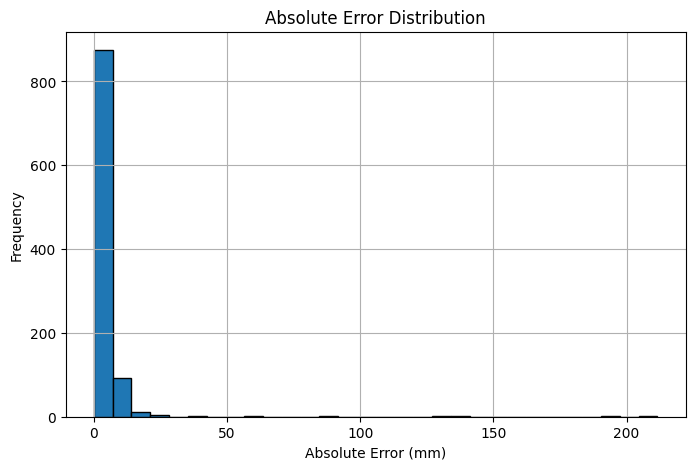

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_out['abs_error'], bins=30, edgecolor='black')
plt.title("Absolute Error Distribution")
plt.xlabel("Absolute Error (mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

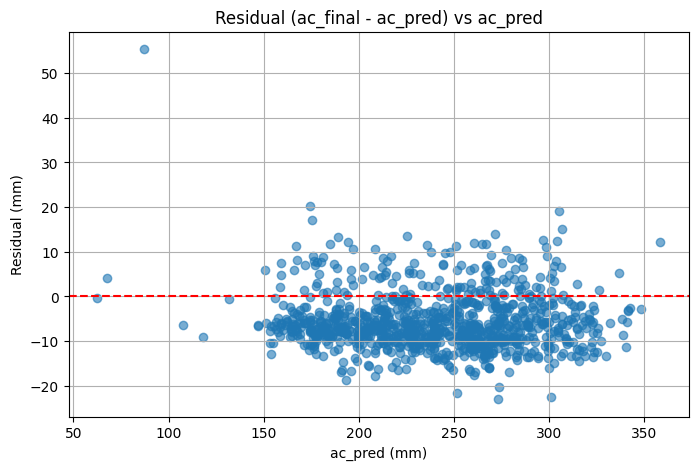

In [20]:
plt.figure(figsize=(8, 5))
plt.scatter(df_out['ac_pred'], df_out['residual_pred'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual (ac_final - ac_pred) vs ac_pred")
plt.xlabel("ac_pred (mm)")
plt.ylabel("Residual (mm)")
plt.grid(True)
plt.show()

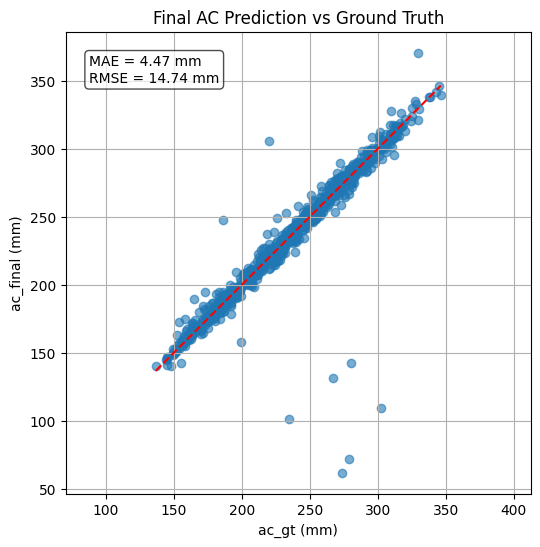

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(df_out['ac_gt'], df_out['ac_final'], alpha=0.6)
plt.plot([df_out['ac_gt'].min(), df_out['ac_gt'].max()],
         [df_out['ac_gt'].min(), df_out['ac_gt'].max()],
         color='red', linestyle='--')  # y=x 参考线
plt.title("Final AC Prediction vs Ground Truth")
plt.xlabel("ac_gt (mm)")
plt.ylabel("ac_final (mm)")
plt.grid(True)
plt.axis("equal")
mae = df_out["abs_error"].mean()
rmse = np.sqrt((df_out["abs_error"]**2).mean())
plt.text(0.05, 0.95, f"MAE = {mae:.2f} mm\nRMSE = {rmse:.2f} mm",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))
plt.show()



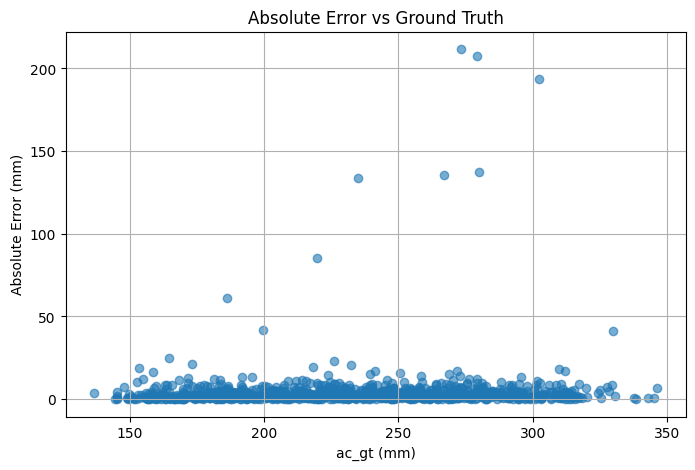

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(df_out['ac_gt'], df_out['abs_error'], alpha=0.6)
plt.title("Absolute Error vs Ground Truth")
plt.xlabel("ac_gt (mm)")
plt.ylabel("Absolute Error (mm)")
plt.grid(True)
plt.show()

In [23]:
print(df_out.describe())

          ac_pred  residual_pred    ac_final       ac_gt   abs_error
count  993.000000     993.000000  993.000000  993.000000  993.000000
mean   238.739094      -5.672062  233.067032  233.541833    4.465207
std     46.091429       6.381383   46.191311   45.155852   14.056997
min     62.250000     -23.015381   61.796612  136.639999    0.000916
25%    203.429993      -9.518250  196.489441  197.190002    0.946594
50%    239.860001      -6.829681  232.846588  233.769989    2.315338
75%    272.529999      -2.988449  268.131775  268.820007    4.501160
max    358.549988      55.347588  370.777710  346.469971  211.603382


In [24]:
import numpy as np

thresholds = [1, 2, 3, 4, 5]
total = len(df_out)

print("Absolute Error Threshold Stats:")
for t in thresholds:
    count = (df_out['abs_error'] <= t).sum()
    percentage = 100.0 * count / total
    print(f"≤ {t} mm: {count}/{total} ({percentage:.2f}%)")

Absolute Error Threshold Stats:
≤ 1 mm: 260/993 (26.18%)
≤ 2 mm: 446/993 (44.91%)
≤ 3 mm: 593/993 (59.72%)
≤ 4 mm: 702/993 (70.69%)
≤ 5 mm: 783/993 (78.85%)


In [25]:
quartiles = np.percentile(df_out['abs_error'], [25, 50, 75])
print(f"Q1 (25%): {quartiles[0]:.2f} mm")
print(f"Q2 (Median): {quartiles[1]:.2f} mm")
print(f"Q3 (75%): {quartiles[2]:.2f} mm")

Q1 (25%): 0.95 mm
Q2 (Median): 2.32 mm
Q3 (75%): 4.50 mm


# Before Pred

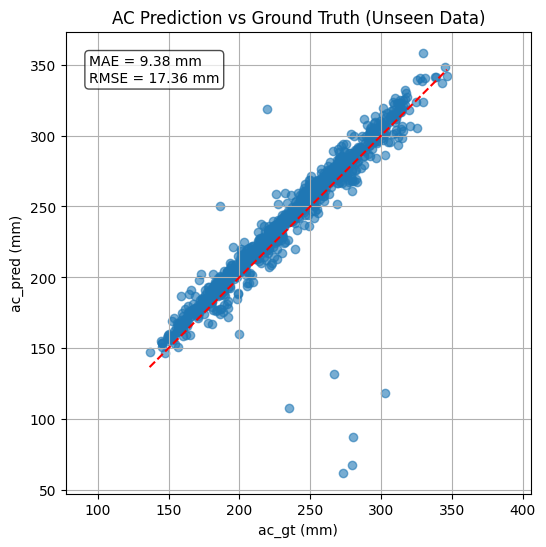

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_test = pd.read_csv("./results/ac_test.csv")

errors = df_test["ac_pred"] - df_test["ac_gt"]
mae = np.abs(errors).mean()
rmse = np.sqrt((errors ** 2).mean())

plt.figure(figsize=(6, 6))
plt.scatter(df_test['ac_gt'], df_test['ac_pred'], alpha=0.6)
plt.plot([df_test['ac_gt'].min(), df_test['ac_gt'].max()],
         [df_test['ac_gt'].min(), df_test['ac_gt'].max()],
         color='red', linestyle='--')  # y=x 参考线

plt.title("AC Prediction vs Ground Truth (Unseen Data)")
plt.xlabel("ac_gt (mm)")
plt.ylabel("ac_pred (mm)")
plt.grid(True)
plt.axis("equal")
plt.text(0.05, 0.95, f"MAE = {mae:.2f} mm\nRMSE = {rmse:.2f} mm",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round", facecolor='white', alpha=0.7))
plt.show()

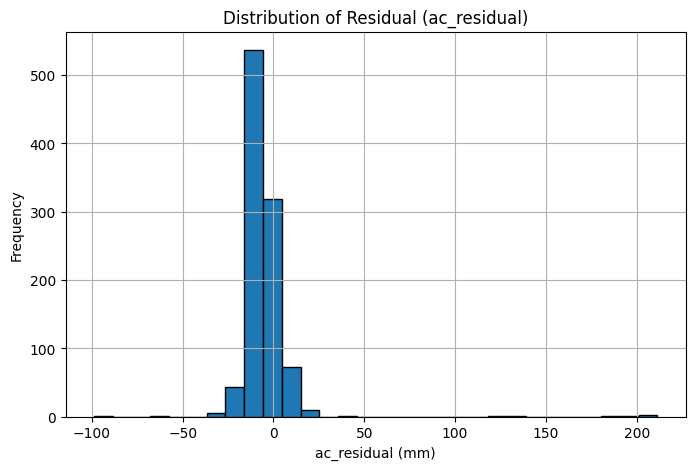

In [27]:
plt.figure(figsize=(8, 5))
plt.hist(df_test['ac_residual'], bins=30, edgecolor='black')
plt.title("Distribution of Residual (ac_residual)")
plt.xlabel("ac_residual (mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

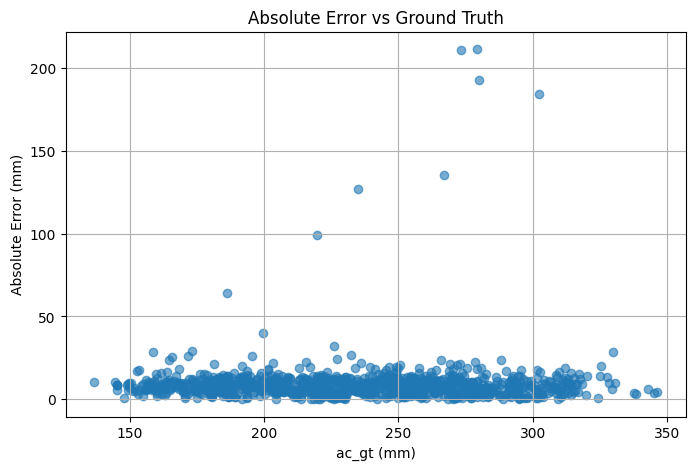

In [28]:
abs_error = np.abs(df_test["ac_pred"] - df_test["ac_gt"])

plt.figure(figsize=(8, 5))
plt.scatter(df_test['ac_gt'], abs_error, alpha=0.6)
plt.title("Absolute Error vs Ground Truth")
plt.xlabel("ac_gt (mm)")
plt.ylabel("Absolute Error (mm)")
plt.grid(True)
plt.show()

# Several methods of morphological processing

In [29]:
def smooth_with_gaussian_colored(mask_path):
    # 读取 & 转换为二值图
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_bin = np.where(mask == 255, 1, mask).astype(np.uint8)
    _, binary = cv2.threshold(mask_bin, 0, 255, cv2.THRESH_BINARY)

    # 高斯模糊 + 二值化
    blurred = cv2.GaussianBlur(binary, (71, 71), 0)
    _, smoothed = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # 生成彩色展示图
    color_orig = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    color_smooth = cv2.cvtColor(smoothed, cv2.COLOR_GRAY2BGR)

    color_orig[binary == 255] = [0, 255, 0]       # 原mask绿色
    color_smooth[smoothed == 255] = [0, 0, 255]   # 平滑mask红色

    # 显示
    plt.subplot(1, 2, 1)
    plt.imshow(color_orig)
    plt.title('Original Mask (Green)')

    plt.subplot(1, 2, 2)
    plt.imshow(color_smooth)
    plt.title('Gaussian Smoothed (Red)')

    plt.tight_layout()
    plt.show()
mask_path = "../../training_data/masks_pred/frame_000300.png"
smooth_with_gaussian_colored(mask_path)

[ WARN:0@1005.396] global loadsave.cpp:248 findDecoder imread_('../../training_data/masks_pred/frame_000300.png'): can't open/read file: check file path/integrity


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [ ]:
def smooth_with_opening_colored(mask_path, kernel_size=5):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_bin = np.where(mask == 255, 1, mask).astype(np.uint8)
    _, binary = cv2.threshold(mask_bin, 0, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    color_orig = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    color_open = cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR)

    color_orig[binary == 255] = [0, 255, 0]
    color_open[opened == 255] = [0, 0, 255]

    plt.subplot(1, 2, 1)
    plt.imshow(color_orig)
    plt.title('Original Mask (Green)')

    plt.subplot(1, 2, 2)
    plt.imshow(color_open)
    plt.title(f'Opening Smooth (kernel={kernel_size})')

    plt.tight_layout()
    plt.show()
mask_path = "../../training_data/masks_pred/frame_000300.png"
smooth_with_opening_colored(mask_path, kernel_size=40)

In [ ]:
def rebuild_as_ellipse(mask_path, min_area=1000):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_bin = np.where(mask == 255, 1, mask).astype(np.uint8)
    _, binary = cv2.threshold(mask_bin, 0, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找面积最大的轮廓
    if not contours:
        raise ValueError("没有检测到轮廓！")

    main_cnt = max(contours, key=cv2.contourArea)

    if cv2.contourArea(main_cnt) < min_area:
        raise ValueError("主轮廓面积过小，可能为噪声")

    # 拟合椭圆
    if len(main_cnt) >= 5:
        ellipse = cv2.fitEllipse(main_cnt)
        ellipse_mask = np.zeros_like(binary)
        cv2.ellipse(ellipse_mask, ellipse, 255, -1)

        # 可视化
        color_orig = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        color_ellipse = cv2.cvtColor(ellipse_mask, cv2.COLOR_GRAY2BGR)
        color_orig[binary == 255] = [0, 255, 0]
        color_ellipse[ellipse_mask == 255] = [0, 0, 255]

        plt.subplot(1, 2, 1)
        plt.imshow(color_orig)
        plt.title('Original Mask (Green)')

        plt.subplot(1, 2, 2)
        plt.imshow(color_ellipse)
        plt.title('Rebuilt Ellipse (Red)')
        plt.tight_layout()
        plt.show()

mask_path = "../../training_data/masks_pred/frame_000300.png"
rebuild_as_ellipse(mask_path)

# Detecting the difference between the actual mask and the predicted mask

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def compare_masks(file_name):
    # 路径配置
    true_path = os.path.join("../../training_data/segmentation_dataset/masks", file_name)
    pred_path = os.path.join("../../training_data/masks_pred", file_name)

    # 读取mask
    true_mask = cv2.imread(true_path, cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    if true_mask is None or pred_mask is None:
        raise FileNotFoundError("某一张 mask 文件未能正确读取。请检查路径是否存在。")

    # 确保维度一致
    if true_mask.shape != pred_mask.shape:
        raise ValueError("两个 mask 尺寸不一致，不能比较。")

    # 比较分析
    diff = (true_mask != pred_mask).astype(np.uint8)

    true_area = (true_mask == 1).sum()
    pred_area = (pred_mask == 1).sum()
    intersection = np.logical_and(true_mask == 1, pred_mask == 1).sum()
    union = true_area + pred_area
    dice = 2 * intersection / union if union > 0 else 1.0
    same_ratio = np.sum(true_mask == pred_mask) / true_mask.size
    diff_pixels = np.sum(diff)

    # 打印关键数值
    print(" 详细对比信息：")
    print(f"- Ground Truth mask area (label=1): {true_area}")
    print(f"- Predicted mask area (label=1):    {pred_area}")
    print(f"- Intersection:                     {intersection}")
    print(f"- Union:                            {union}")
    print(f"- Dice Coefficient:                 {dice:.4f}")
    print(f"- Same pixels ratio:                {same_ratio:.2%}")
    print(f"- Different pixels:                 {diff_pixels}")
    print(f"- Image shape:                      {true_mask.shape}")

    # 可视化
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(diff * 255, cmap='Reds')
    plt.title("Difference (Red = mismatch)")

    plt.suptitle(f"Dice = {dice:.4f} | Same = {same_ratio:.2%} | Diff = {diff_pixels}")
    plt.tight_layout()
    plt.show()

# 用例：frame_000123.png
compare_masks("frame_000123.png")


In [ ]:
print("Unique values in true_mask:", np.unique(mask_path))
